In [1]:
%matplotlib inline
from astropy.stats import sigma_clipped_stats
from photutils import CircularAperture, aperture_photometry, CircularAnnulus, DAOStarFinder
import astropy.io.fits as pf
import numpy as np
import seaborn as sns
sns.set()
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.wcs import WCS
from matplotlib import pyplot as plt
import os
from scipy import stats
from scipy.optimize import curve_fit
from scipy import odr

In [16]:
os.chdir(r'C:\Users\garyc\Desktop\4th Year\Astro Project')
file = 'wcsT_0256.fits'
image = pf.open(file)
w = WCS(image[0].header)
sky = w.pixel_to_world(815,833)
print(sky)

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (82.1633082, 42.43776573)>


In [25]:
x = [82.183071,82.177918,82.134288,82.192476,82.156488,82.129231]
y = [42.446424,42.454144,42.438220,42.437444,42.416215,42.421826]
a = []
b = []
for i,j in zip(x,y):
    px, py = w.wcs_world2pix(i,j, 1)
    a.append(px)
    b.append(py)
    print('{0} {1}'.format(px, py))

649.2089265386021 733.2154352484699
693.635400603499 644.9919324634594
1062.047933754848 830.8197127843185
568.5961126056515 835.5824885814933
871.7684454460186 1081.8215081575886
1103.4629700845285 1019.3117106389998


In [33]:
x = [82.183071,82.177918,82.134288,82.192476,82.156488]
y = [42.446424,42.454144,42.438220,42.437444,42.416215]
a = []
b = []
for i,j in zip(x,y):
    px, py = w.wcs_world2pix(i,j, 1)
    a.append(px)
    b.append(py)
    #print('{0} {1}'.format(px, py))
    
os.chdir(r'C:\Users\garyc\Desktop\4th Year\Astro Project\2V Reduced\1500 1500 files')
file = 'reduceducdT_0256.fits'
image = pf.getdata(file)

a = np.array(a)
b = np.array(b)
a = a
b = b
print(a)
print(b)
mean, median, std = sigma_clipped_stats(image, sigma=3)
daofind = DAOStarFinder(fwhm=5.0, threshold=3*std) 
sources = daofind(image - median)
for col in sources.colnames: 
    sources[col].info.format = '%.8g'

positions = []
for i,j in zip(a,b):
    ID = []
    xref = i
    yref = j
    for k,l,m in zip(sources['xcentroid'],sources['ycentroid'],sources['id']):
        if -5<(k-xref)<5 and -5<(l-yref)<5:
            n = m-1
            ID.append(n)
            positions.append((k,l))
    print(sources[ID])

[ 649.20892654  693.6354006  1062.04793375  568.59611261  871.76844545]
[ 733.21543525  644.99193246  830.81971278  835.58248858 1081.82150816]
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
745 648.86803 730.48546 0.35327443 ...   0 348.17477 7.7868864 -2.2284096
 id xcentroid ycentroid sharpness  ... sky    peak      flux       mag    
--- --------- --------- ---------- ... --- --------- --------- -----------
653  693.1642 640.43808 0.86774939 ...   0 96.820502 1.9074618 -0.70113963
 id xcentroid ycentroid sharpness  ... sky   peak      flux      mag    
--- --------- --------- ---------- ... --- -------- --------- ----------
835 1062.5341 829.28919 0.32544025 ...   0 595.8558 12.477049 -2.7402797
 id xcentroid ycentroid sharpness  ... sky    peak     flux      mag    
--- --------- --------- ---------- ... --- --------- -------- ----------
838 566.36601 834.17857 0.41443379 ...   0 8

In [34]:
mags = []
magserrors = []
for i in positions:
    aperture = CircularAperture(i, r=9) 
    annulus_aperture = CircularAnnulus(i, r_in=12., r_out=15.)
    apers = [aperture, annulus_aperture]
    phot_table = aperture_photometry(image, apers)
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g'
    bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
    bkg_total = bkg_mean * aperture.area
    net_star = phot_table['aperture_sum_0'] - bkg_total
    mags.append(-2.5*np.log10(phot_table['aperture_sum_0'][0]))
    dfdx = -1.08574/phot_table['aperture_sum_0'][0]
    error = np.sqrt((dfdx**2)*(np.sqrt(phot_table['aperture_sum_0'][0]))**2)
    magserrors.append(error)

[  0.51292367 -20.00578826]
[[ 0.00369297 -0.04305079]
 [-0.04305079  0.51635092]]
Beta: [  0.55587594 -20.45554092]
Beta Std Error: [0.08133866 1.01197353]
Beta Covariance: [[ 6.46714102e-05 -7.95173824e-04]
 [-7.95173824e-04  1.00105190e-02]]
Residual Variance: 102.30143289933561
Inverse Condition #: 0.05655424176123601
Reason(s) for Halting:
  Sum of squares convergence


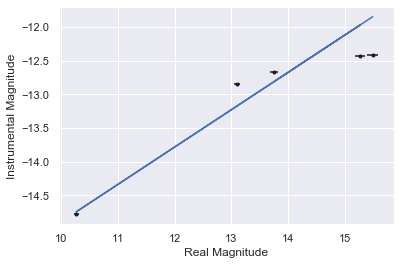

In [35]:
mags = np.array(mags)
realmag = [13.746,15.261,13.106,10.272,15.487]


realmag = np.array(realmag)
realmagerrors = [0.073,0.093,0.055,0.041,0.099]

plt.errorbar(realmag,mags,magserrors,realmagerrors,fmt='.',color='k')
plt.ylabel('Instrumental Magnitude')
plt.xlabel('Real Magnitude')

def f(x,m,c):
    return m*x+c
popt, pcov = curve_fit(f,realmag,mags,sigma=magserrors)
print(popt)

def func(p, x):
    m, c = p
    return m*x + c
mydata = odr.RealData(realmag, mags, sx = realmagerrors, sy = magserrors)
linear = odr.Model(func)
myodr = odr.ODR(mydata, linear,beta0 =[1, -23])
myoutput = myodr.run()
y = myoutput.beta[0]*realmag+myoutput.beta[1]
plt.plot(realmag,y)
print(pcov)
myoutput.pprint()

In [36]:
xref = 816
yref = 831

mean, median, std = sigma_clipped_stats(image, sigma=3)
daofind = DAOStarFinder(fwhm=4.0, threshold=3*std) 
sources = daofind(image - median)
for col in sources.colnames: 
    sources[col].info.format = '%.8g'
for k,l,m in zip(sources['xcentroid'],sources['ycentroid'],sources['id']):
    if -10<(k-xref)<10 and -10<(l-yref)<10:
        n = m-1
        ID.append(n)
print(sources[ID])

 id  xcentroid ycentroid sharpness  ... sky    peak      flux       mag     
---- --------- --------- ---------- ... --- --------- --------- ------------
1090 495.14911  753.5957 0.58145799 ...   0 24.715146 1.0589613 -0.062200263
1187 814.18956 833.29424 0.37887543 ...   0 12812.505 126.01511   -5.2510566


In [47]:
sourcemag = []
sourcemagerror = []
position = [(814.18956,833.29424)]
aperture = CircularAperture(position[0], r=9) 
annulus_aperture = CircularAnnulus(position[0], r_in=12., r_out=15.)
apers = [aperture, annulus_aperture]
phot_table = aperture_photometry(image, apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
bkg_total = bkg_mean * aperture.area
net_star = phot_table['aperture_sum_0'] - bkg_total
sourcemag.append(-2.5*np.log10(phot_table['aperture_sum_0'][0]))
sourcemagerror.append((-1.08574/phot_table['aperture_sum_0'][0])*np.sqrt(phot_table['aperture_sum_0'][0]))
print(sourcemag)

[-15.1044476218013]


In [48]:
dy = 1/myoutput.beta[0]
dc = -1/myoutput.beta[0]
dm = (myoutput.beta[1]-sourcemag[0])/(myoutput.beta[0])**2
error = np.sqrt((dy**2)*sourcemagerror[0]**2+(dc**2)*(myoutput.sd_beta[1])**2+(dm**2)*(myoutput.sd_beta[0])**2)
print((sourcemag[0]-myoutput.beta[1])/myoutput.beta[0],'+/-',error)

9.626416491009369 +/- 2.301814773905203


In [15]:
print(phot_table['aperture_sum_0'][0])

1100979.0339037497
